# Investigation

The API homepage lets you download CSVs of historical forecast and actual CI. These are (presumably) the final forecast values for the given time window. Here I check the forecast error.

In [1]:
%matplotlib inline

import os
from datetime import datetime, timezone, timedelta
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scrape.files import get_data_files
from scrape.graph import _ftime, _aggregate_per, get_dates
from scrape.graph import get_merged_summaries_with_final_actual_intensities, _error_and_percentage_error

plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 250

# Get data files 2022-23
files = get_data_files("data/samples", extension=".csv")

df = pd.concat([pd.read_csv(fp, index_col=0) for fp in sorted(files)])

# Drop duplicates from overlapping dates
df = df[~df.index.duplicated(keep="last")]

df.index = pd.to_datetime(df.index)

In [2]:
df["error"] = df["Forecast Carbon Intensity (gCO2/kWh)"].sub(df["Actual Carbon Intensity (gCO2/kWh)"])
df["percentage error"] = 100. * df["error"].div(df["Actual Carbon Intensity (gCO2/kWh)"])
df.tail()

Actual Carbon Intensity (gCO2/kWh)  \
Datetime (UTC)                                                  
2023-03-30 22:00:00+00:00                                81.0   
2023-03-30 22:30:00+00:00                                77.0   
2023-03-30 23:00:00+00:00                                78.0   
2023-03-30 23:30:00+00:00                                77.0   
2023-03-31 00:00:00+00:00                                82.0   

                           Forecast Carbon Intensity (gCO2/kWh) Index  error  \
Datetime (UTC)                                                                 
2023-03-30 22:00:00+00:00                                   139   low   58.0   
2023-03-30 22:30:00+00:00                                   129   low   52.0   
2023-03-30 23:00:00+00:00                                   105   low   27.0   
2023-03-30 23:30:00+00:00                                    85   low    8.0   
2023-03-31 00:00:00+00:00                                    81   low   -1.0   

                           percentage error  
Datetime (UTC)                               
2023-03-30 22:00:00+00:00         71.604938  
2023-03-30 22:30:00+00:00         67.532468  
2023-03-30 23:00:00+00:00         34.615385  
2023-03-30 23:30:00+00:00         10.389610  
2023-03-31 00:00:00+00:00         -1.219512

2017: mean 9.176311999523838, std 13.679474837027618
2018: mean 10.822421092169625, std 34.67726398646401
2019: mean 5.908749639934832, std 56.70681449783952
2020: mean 6.315442144994107, std 9.279700400943442
2021: mean 5.450166185300275, std 8.016490329398568
2022: mean 6.401842465289679, std 10.512159106586562
2023: mean 7.907825272072335, std 12.748422111917812


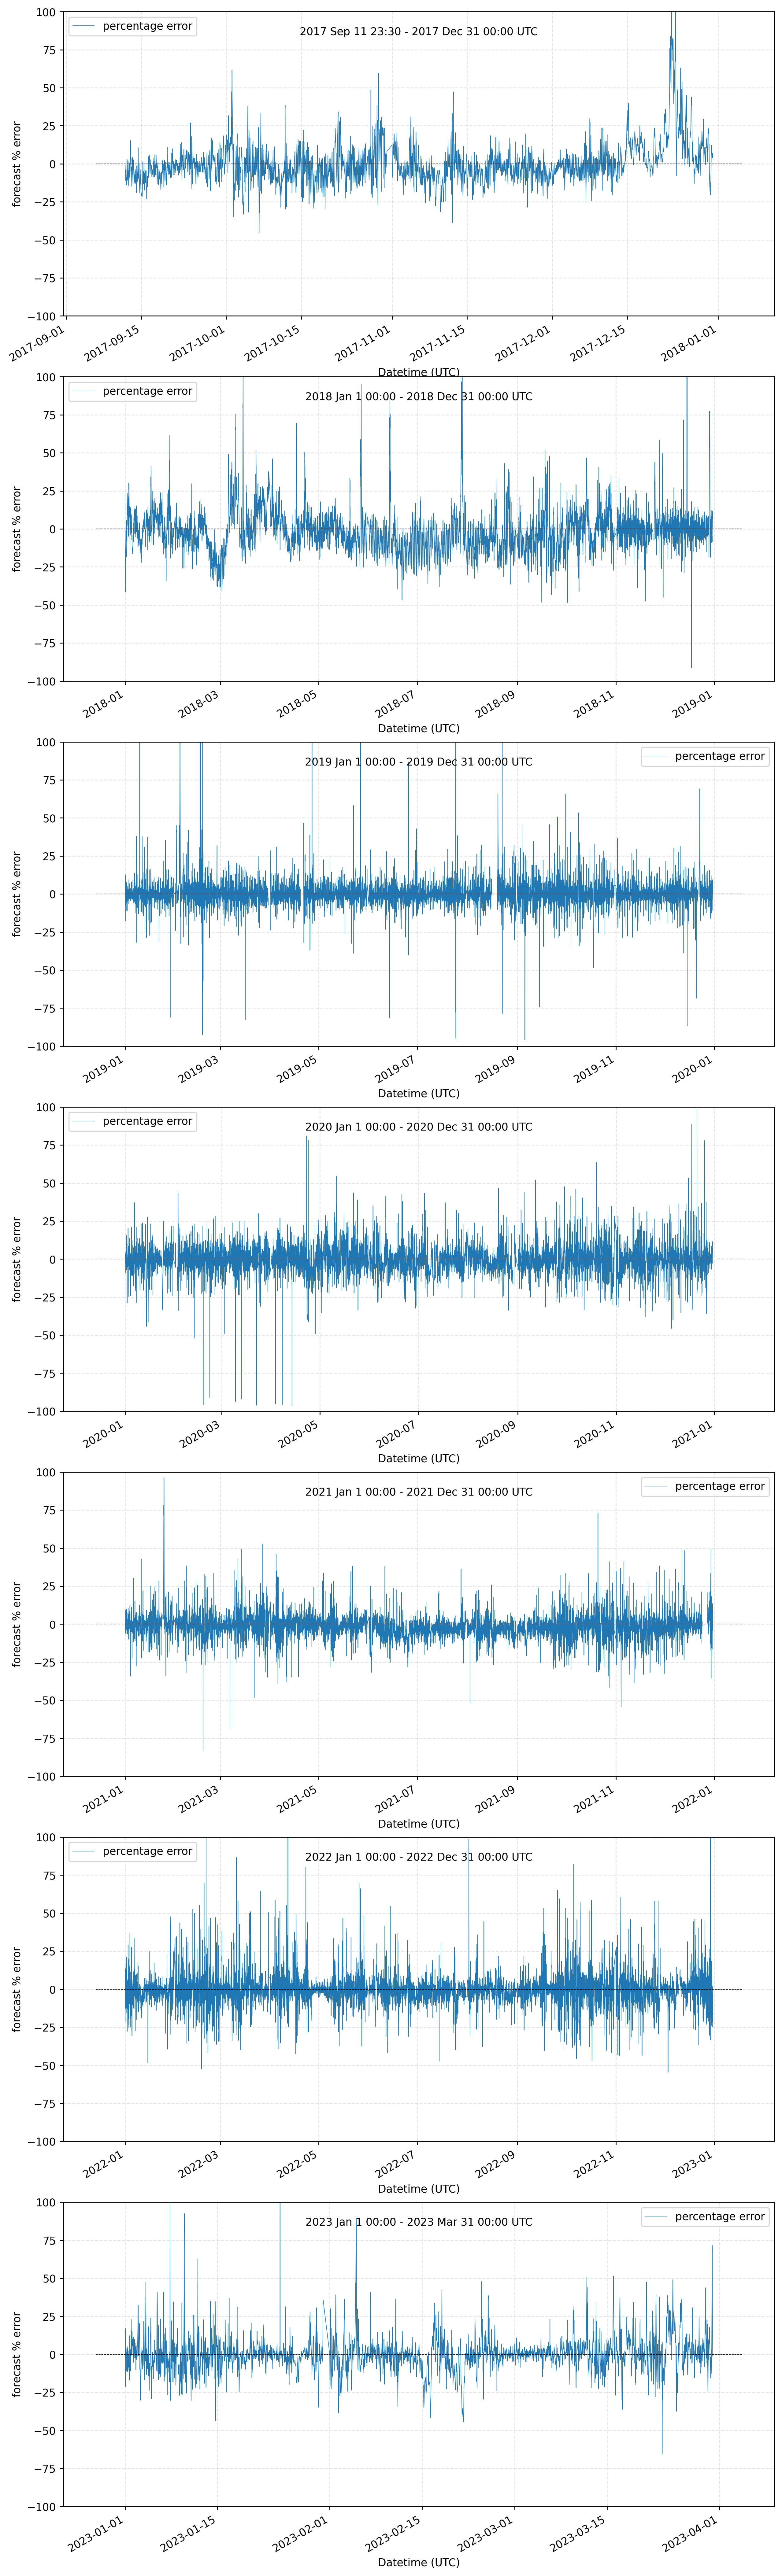

In [3]:
# Get unique years from the index and plot by year
years = list({dt.year: "" for dt in df.index}.keys())

plt.rcParams['figure.figsize'] = [12, 48]
plt.rcParams['figure.dpi'] = 250

fig, axes = plt.subplots(len(years), 1, sharex=False, sharey="col")
for ix, ax in enumerate(axes):
    dates = [d for d in df.index if d.year == years[ix]]
    df.loc[dates, ["percentage error"]].plot(ax=ax, linewidth=0.5)
    
    title = f"{_ftime(dates[0])} - {_ftime(dates[-1])} UTC"
    ax.text(0.5, 0.95, title, horizontalalignment='center', verticalalignment='top', transform = ax.transAxes)
    
#     ax.set_title()
    ax.set_ylabel("forecast % error")
    ax.grid("on", linestyle="--", alpha=0.33)
    ax.hlines(
        0.0,
        ax.get_xlim()[0],
        ax.get_xlim()[-1],
        color="k",
        linestyle="--",
        linewidth=0.5,
    )
    
    # The mean absolute percentage error for the entire period, and the standard deviation (of the raw errors)
    year_mean = df.loc[dates, ["percentage error"]].abs().mean()
    year_std = df.loc[dates, ["percentage error"]].std()
    print(f"{dates[0].year}: mean {float(year_mean)}, std {float(year_std)}")

ax.set_ylim(-100,100)
plt.show()

All years combined:

Text(0.5, 0.98, 'Percentage national forecast error, 95407 half-hour windows')

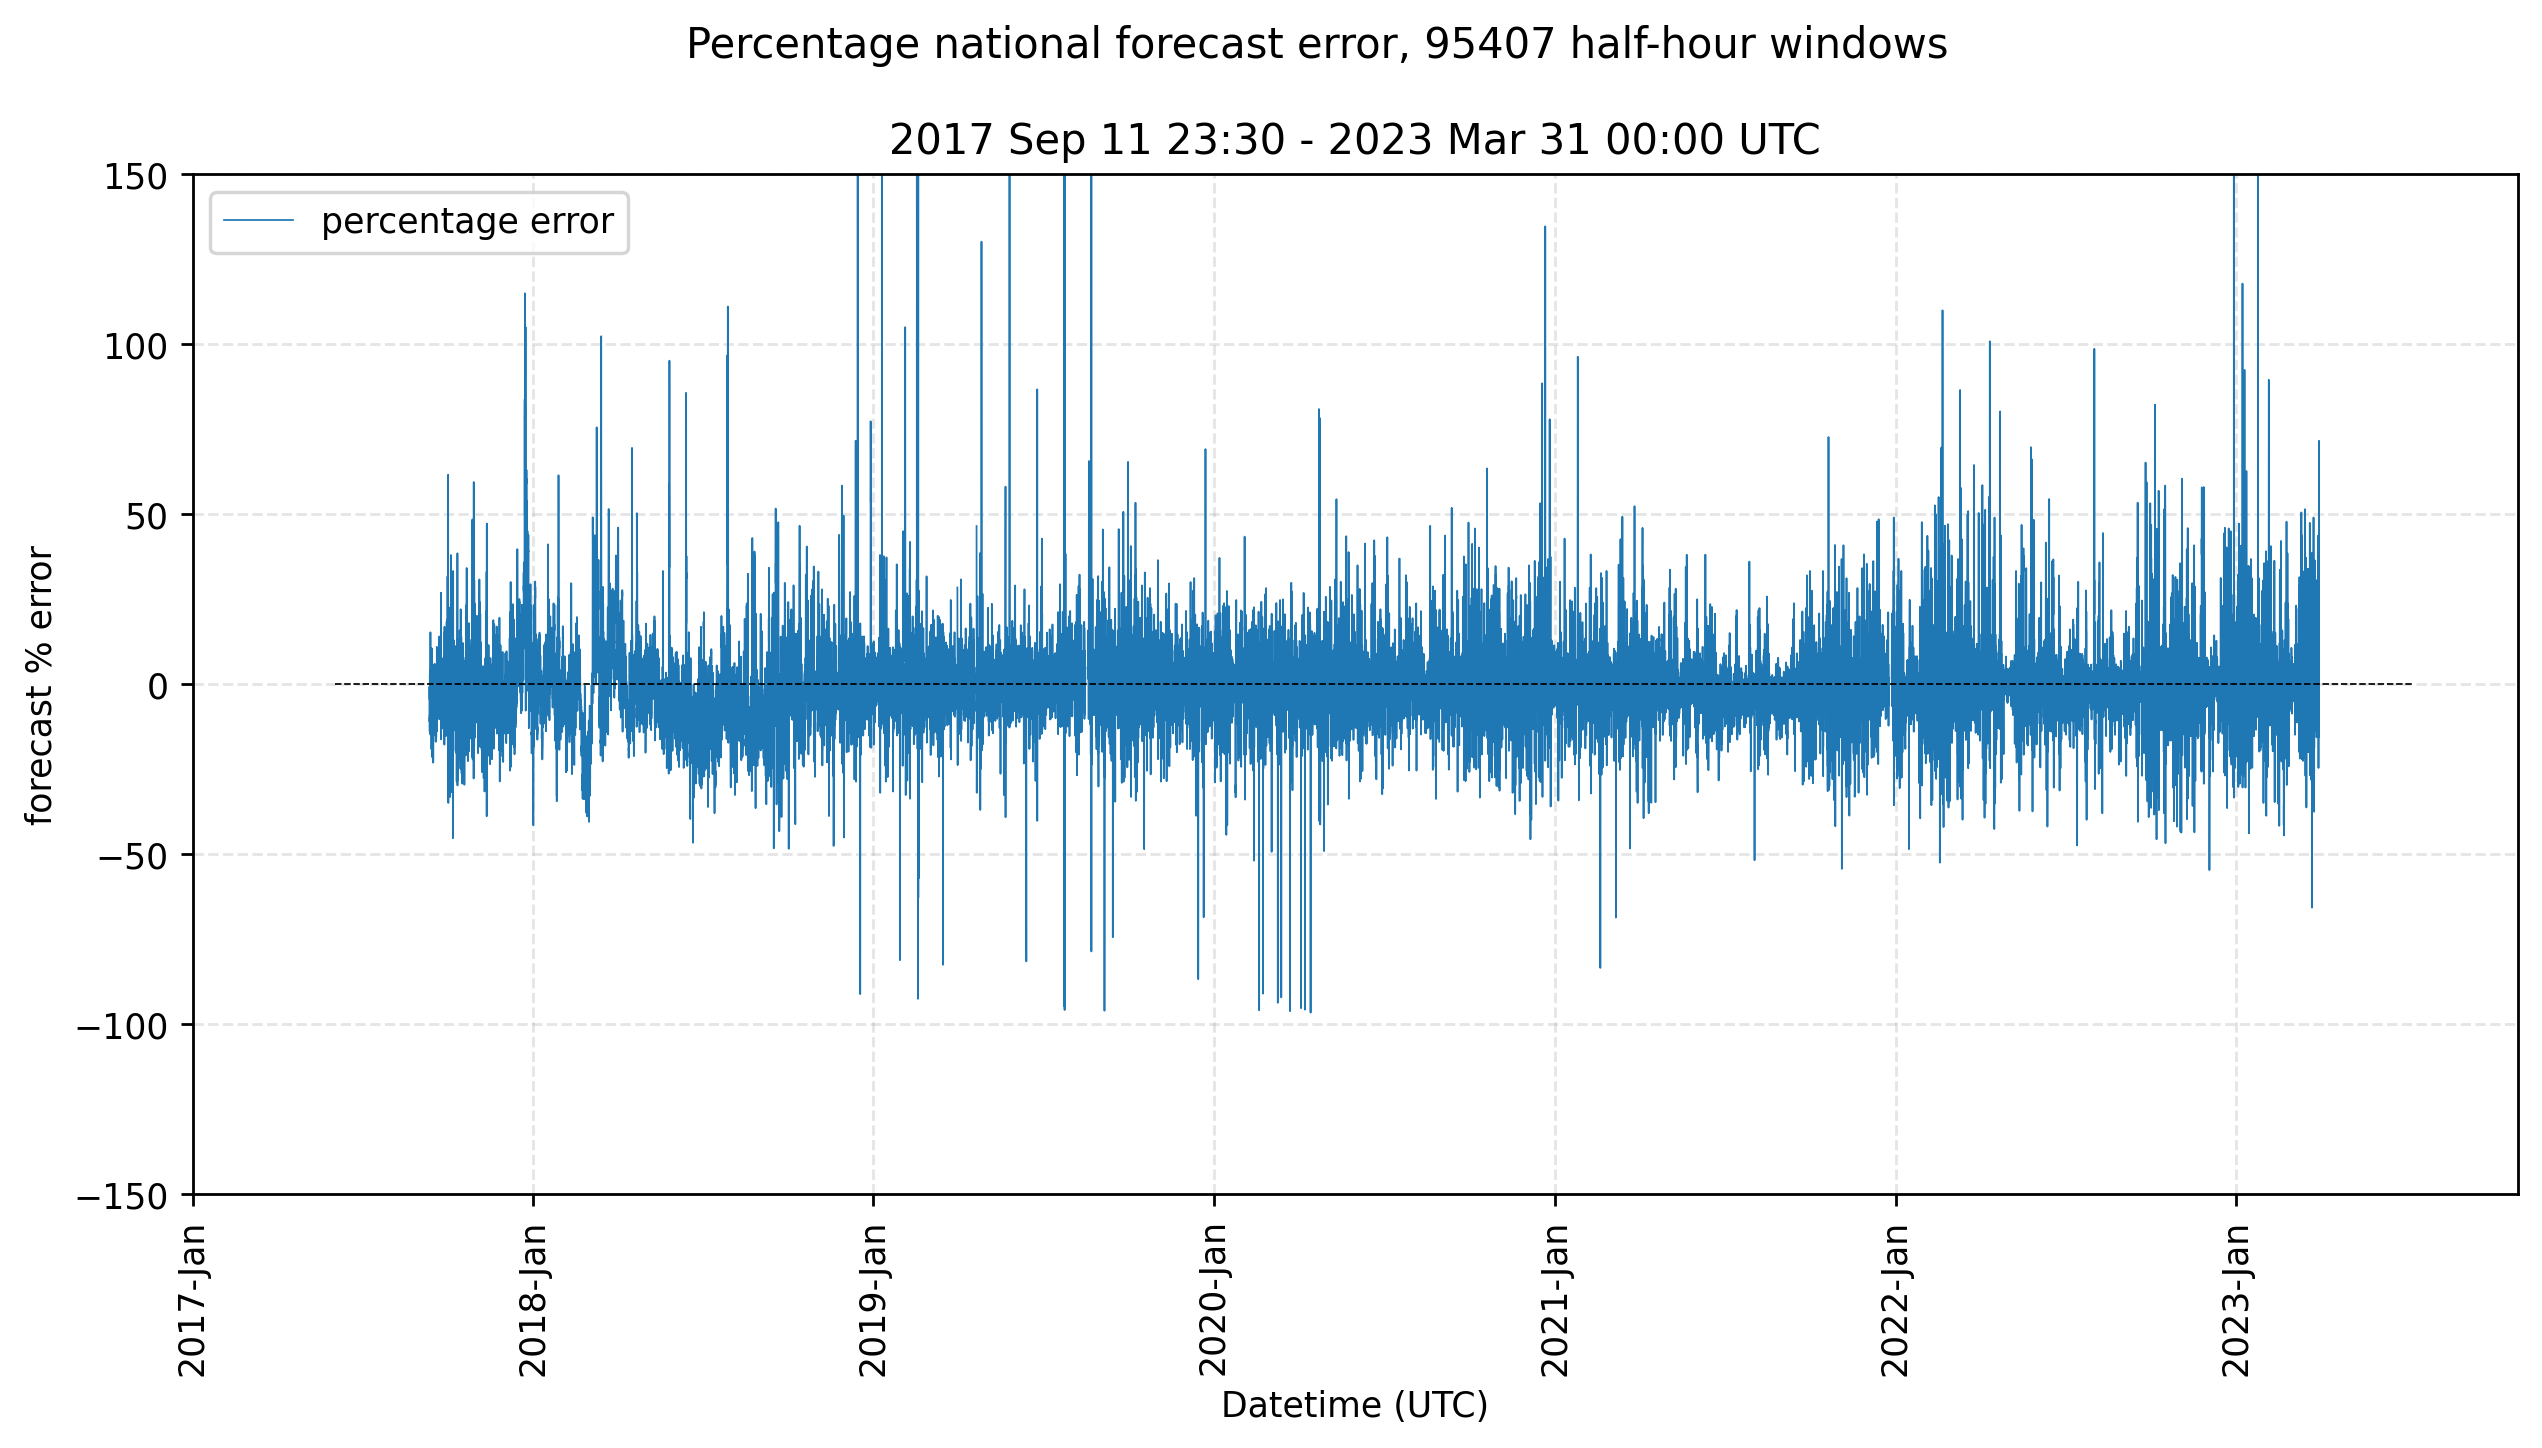

In [44]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 250

ax = df.plot(use_index=True, y="percentage error", linewidth=0.5, label=r"percentage error")

ax.set_ylim(-150,150)
ax.set_title(f"{_ftime(df.index[0])} - {_ftime(df.index[-1])} UTC")
ax.set_ylabel("forecast % error")
ax.grid("on", linestyle="--", alpha=0.33)
ax.hlines(
    0.0,
    ax.get_xlim()[0],
    ax.get_xlim()[-1],
    color="k",
    linestyle="--",
    linewidth=0.5,
)

xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()

ax.set_xticks(xticks, xlabels, rotation=90, ha="center")

# locator = mdates.MonthLocator(interval=1)  # every month
locator = mdates.YearLocator()
fmt = mdates.DateFormatter("%Y-%b")
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)

fig = plt.gcf()
fig.suptitle(f"Percentage national forecast error, {len(df.index)} half-hour windows")

In [45]:
# The mean absolute percentage error for the entire period, and the standard deviation (of the raw errors)
print(df["percentage error"].abs().mean(), df["percentage error"].std())

7.147381369675848 29.26346713524063


## Problematic errors

How big can an error be before it is problematic?

This depends upon the published CI index boundaries.

In [47]:
df_ci

very low      low      moderate      high      very high
Year / Index     from  to from   to     from   to from   to      from
2017                0  99  100  199      200  299  300  400       401
2018                0  79   80  179      180  279  280  380       381
2019                0  59   60  159      160  259  260  360       361
2020                0  54   55  149      150  229  230  350       351
2021                0  49   50  139      140  219  220  330       331
2022                0  44   45  129      130  209  210  310       311
2023                0  39   40  119      120  199  200  290       291
2024                0  34   35  109      110  189  190  270       271
2025                0  29   30   99      100  179  180  250       251
2026                0  24   25   89       90  169  170  230       231
2027                0  19   20   79       80  159  160  210       211
2028                0  14   15   69       70  149  150  190       191
2029                0   9   10   59       60  139  140  170       171
2030                0   4    5   49       50  129  130  150       151

In [109]:
df_ci = pd.read_csv("data/artifacts/ci_index_numerical_bands.csv", index_col=0, header=[0,1])

cols = [(title, metric) for title in ["moderate - very low", "high - low", "very high - moderate"] for metric in ["difference", "percentage"]]

df_comp = pd.DataFrame(columns=pd.MultiIndex.from_tuples(cols), index=df_ci.index)

for ix, row in df_ci.iterrows():
    diff = row["moderate"]["from"] - row["very low"]["to"]
    df_comp.loc[ix, pd.IndexSlice["moderate - very low", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["moderate - very low", "percentage"]] = 100. * diff / row["moderate"]["from"]
    
    diff = row["high"]["from"] - row["low"]["to"]
    df_comp.loc[ix, pd.IndexSlice["high - low", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["high - low", "percentage"]] = 100. * diff / row["high"]["from"]
    
    diff = row["very high"]["from"] - row["moderate"]["to"]
    df_comp.loc[ix, pd.IndexSlice["very high - moderate", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["very high - moderate", "percentage"]] = 100. * diff / row["very high"]["from"]
    
# saved to "data/artifacts/ci_index_numerical_band_error_scales.csv"

These are the absolute CI values ($gCO_2/kWh$) and percentage errors necessary (from the measured value) for a forecast to cross two index boundaries, e.g. from `very low` to `moderate`.

In [110]:
df_comp

moderate - very low            high - low             \
              difference percentage difference percentage   
2017                 101       50.5        101  33.666667   
2018                 101  56.111111        101  36.071429   
2019                 101     63.125        101  38.846154   
2020                  96       64.0         81  35.217391   
2021                  91       65.0         81  36.818182   
2022                  86  66.153846         81  38.571429   
2023                  81       67.5         81       40.5   
2024                  76  69.090909         81  42.631579   
2025                  71       71.0         81       45.0   
2026                  66  73.333333         81  47.647059   
2027                  61      76.25         81     50.625   
2028                  56       80.0         81       54.0   
2029                  51       85.0         81  57.857143   
2030                  46       92.0         81  62.307692   

     very high - moderate             
               difference percentage  
2017                  102  25.436409  
2018                  102  26.771654  
2019                  102  28.254848  
2020                  122  34.757835  
2021                  112  33.836858  
2022                  102  32.797428  
2023                   92   31.61512  
2024                   82  30.258303  
2025                   72  28.685259  
2026                   62  26.839827  
2027                   52   24.64455  
2028                   42  21.989529  
2029                   32   18.71345  
2030                   22  14.569536

In [130]:
# Get the minimum percentages necessary to transition two boundaries (e.g. very low -> moderate)
def problem_percentages(year: int):
    problem_percentages = df_comp.loc[year, pd.IndexSlice[:, ["percentage"]]].values.tolist()
    return problem_percentages
    
problem_percentages(2023)

[67.5, 40.5, 31.61512027491409]

## How likely are such errors?

Fit errors to a distribution.

In [150]:
def normal_distribution(x, mu, sigma):
    return stats.norm.pdf(x, loc=mu, scale=sigma)

def t_distribution(x, mu, sigma, nu):
    return stats.t.pdf(x, df=nu, loc=mu, scale=sigma)

def laplace_distribution(x, mu, b):
    return stats.laplace.pdf(x, loc=mu, scale=b)

def histogram(data, n_bins, density: bool = True):
    # Calculate histogram data
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Calculate the bin width
    bin_width = bin_edges[1] - bin_edges[0]
    return hist, bin_edges, bin_centers, bin_width

def prob_extreme_t(extreme_value, popt_t):
    """Using extreme values +/-"""
    
    extreme_value = np.abs(extreme_value)
    results = []
    
    # Student's t-distribution
    t_cdf = stats.t.cdf(extreme_value, df=popt_t[2], loc=popt_t[0], scale=popt_t[1])
    results.append(1 - t_cdf)
    
    t_cdf = stats.t.cdf(extreme_value * -1., df=popt_t[2], loc=popt_t[0], scale=popt_t[1])
    results.append(t_cdf)
    return np.sum(results)

def prob_extreme_laplace(extreme_value, popt_laplace):
    """Using extreme values +/-"""
    
    extreme_value = np.abs(extreme_value)
    results = []
    
    # Laplace distribution
    laplace_cdf = stats.laplace.cdf(extreme_value, loc=popt_laplace[0], scale=popt_laplace[1])
    results.append(1 - laplace_cdf)
    
    laplace_cdf = stats.laplace.cdf(extreme_value * -1., loc=popt_laplace[0], scale=popt_laplace[1])
    results.append(laplace_cdf)
    return np.sum(results)

def cleanup(df: pd.DataFrame, column_name: str, n_bins:int = 200, max_cutoff: int = 200) -> np.array:
    # Ignore crazy outliers

    c = df.loc[df[column_name].abs() > max_cutoff, column_name].count()
    n = df[column_name].isna().sum()

    df_corr = df.copy()
    df_corr.loc[df_corr[column_name] > max_cutoff, column_name] = np.nan

    # Get non-NaNs
    data = df_corr[np.isfinite(df_corr[column_name])][column_name].values
    print(f"{c} excluded outliers, {n} nans, leaving {len(data)} data points")
    
    ax = df_corr[column_name].hist(bins=n_bins)
    ax.set_title(f"{column_name}: cleaned data")
    return data

### Historical data (2017-2023)

Only one error is available per timepoint.

19 excluded outliers, 609 nans, leaving 94779 data points


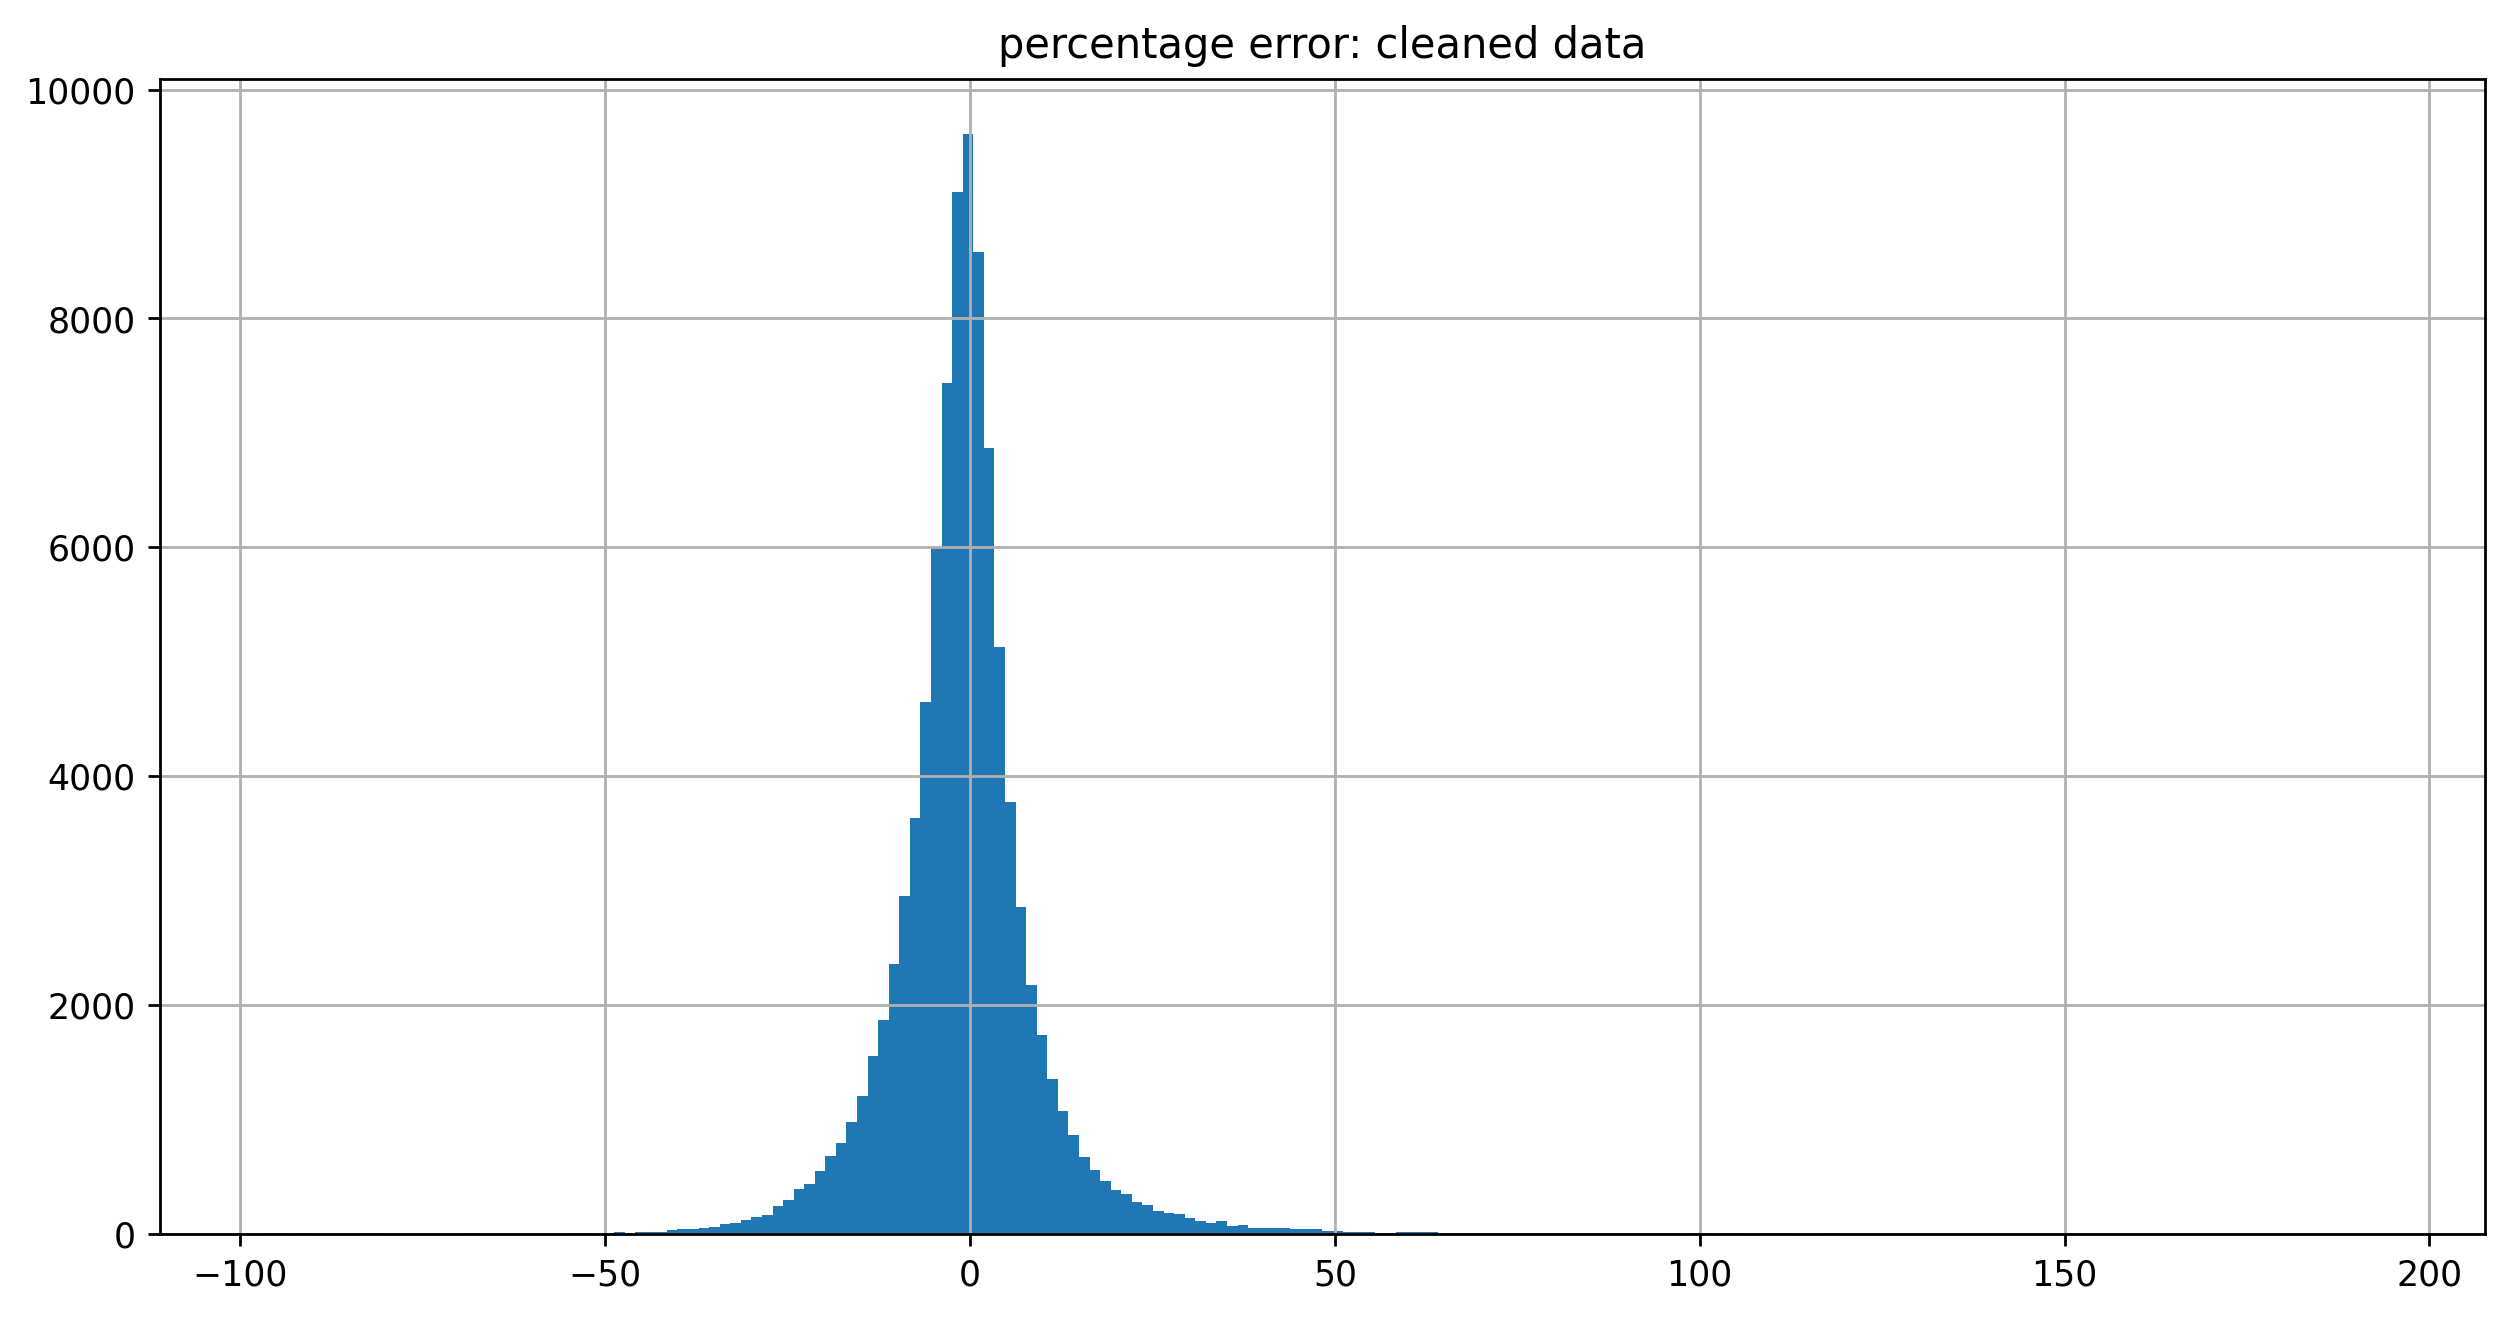

In [101]:
data = cleanup(df, "percentage error", n_bins=200)

Only 39 out of over 95000 data points have a magnitude over 100% error.

In [115]:
def plot_distributions(data: np.array, n_bins: int, density: bool = True, extreme_values: list = []) -> None:
    # Mean, standard deviation, degrees of freedom
    mu = np.mean(data)
    sigma = np.std(data)
    nu = len(data) - 1

    hist, bin_edges, bin_centers, bin_width = histogram(data, n_bins, density)

    # Fit the normal distribution
    popt_norm, _ = curve_fit(normal_distribution, bin_centers, hist, p0=[mu, sigma])

    # Print the optimised parameters
    print("Normal distribution parameters:")
    print(f"Mean: {popt_norm[0]}, Standard deviation: {popt_norm[1]}")

    # Fit Student's t-distribution
    popt_t, _ = curve_fit(t_distribution, bin_centers, hist, p0=[mu, sigma, nu])

    # Print the optimised parameters
    print("Student's t-distribution parameters:")
    print(f"Mean: {popt_t[0]}, Standard deviation: {popt_t[1]}, Degrees of freedom: {popt_t[2]}")

    # Fit the Laplace distribution
    popt_laplace, _ = curve_fit(laplace_distribution, bin_centers, hist, p0=[mu, sigma])

    # Print the optimised parameters
    print("Laplace distribution parameters:")
    print(f"Mean: {popt_laplace[0]}, Scale: {popt_laplace[1]}")

    # If true, give a density plots where the total area under the histogram equals 1.
    density: bool = True
        
    x_min, x_max = -100, 100
    x = np.linspace(x_min, x_max, 1000)

    fig, axes = plt.subplots(1, 2)
    
    ax = axes[0]
    ax.hist(data, bins=n_bins, density=density, alpha=0.6, label="error data")

    if density:
        ax.plot(x, t_distribution(x, *popt_t), label="Student's t", lw=2)
        ax.plot(x, laplace_distribution(x, *popt_laplace), label="Laplace", lw=2)
#         ax.plot(x, normal_distribution(x, *popt_norm), label="Normal distribution", lw=2)
    else:
        # Plot the fitted distributions scaled by the number of data points and bin width
        ax.plot(x, t_distribution(x, *popt_t) * len(data) * bin_width, label="Student's t-distribution", lw=2)
        ax.plot(x, laplace_distribution(x, *popt_laplace) * len(data) * bin_width, label="Laplace distribution", lw=2)
#         ax.plot(x, normal_distribution(x, *popt_norm) * len(data) * bin_width, label="Normal distrubution", lw=2)

    ax.legend()
    ax.grid("on", linestyle="--", alpha=0.33)
    ax.set_xlim(x_min, x_max)
    ylims = ax.get_ylim()
    ax.vlines(
        0.0,
        ylims[0],
        ylims[-1],
        color="k",
        linestyle="--",
        linewidth=0.5,
    )

    # Plot the CDFs to read off probabilities of extreme values
    ax = axes[1]
    
    # Student's t-distribution CDF
    t_cdf_values = stats.t.cdf(x, df=popt_t[2], loc=popt_t[0], scale=popt_t[1])

    # Laplace distribution CDF
    laplace_cdf_values = stats.laplace.cdf(x, loc=popt_laplace[0], scale=popt_laplace[1])
    
    ax.plot(x, t_cdf_values, label="Student's t CDF", lw=2, c="tab:orange")
    ax.plot(x, laplace_cdf_values, label="Laplace CDF", lw=2, c="tab:green")

    ax.set_xlabel("Error (percent)")
    ax.set_ylabel("cumulative probability")
    ax.legend()
    ax.grid("on", linestyle="--", alpha=0.33)
    ax.set_xlim(x_min, x_max)
    
    for extval in extreme_values:
        prob_t = prob_extreme_t(extval, popt_t)
        prob_laplace = prob_extreme_laplace(extval, popt_laplace)
        print(f"Total probability of extreme value {extval} (Student's t-distribution): {prob_t}")
        print(f"Total probability of extreme value {extval} (Laplace distribution): {prob_laplace}")

Normal distribution parameters:
Mean: -0.8214593288241546, Standard deviation: 6.358409549573911
Student's t-distribution parameters:
Mean: -0.8252414814977792, Standard deviation: 6.351431111121584, Degrees of freedom: 3298650.565863029
Laplace distribution parameters:
Mean: -0.7441161029287758, Scale: 6.301525439366653
Total probability of extreme value 67.5 (Student's t-distribution): 4.434546241377384e-26
Total probability of extreme value 67.5 (Laplace distribution): 2.2438413973668314e-05
Total probability of extreme value 40.5 (Student's t-distribution): 2.482667539637421e-10
Total probability of extreme value 40.5 (Laplace distribution): 0.0016285596008847913
Total probability of extreme value 31.61512027491409 (Student's t-distribution): 7.876863868990945e-07
Total probability of extreme value 31.61512027491409 (Laplace distribution): 0.006670220483150014


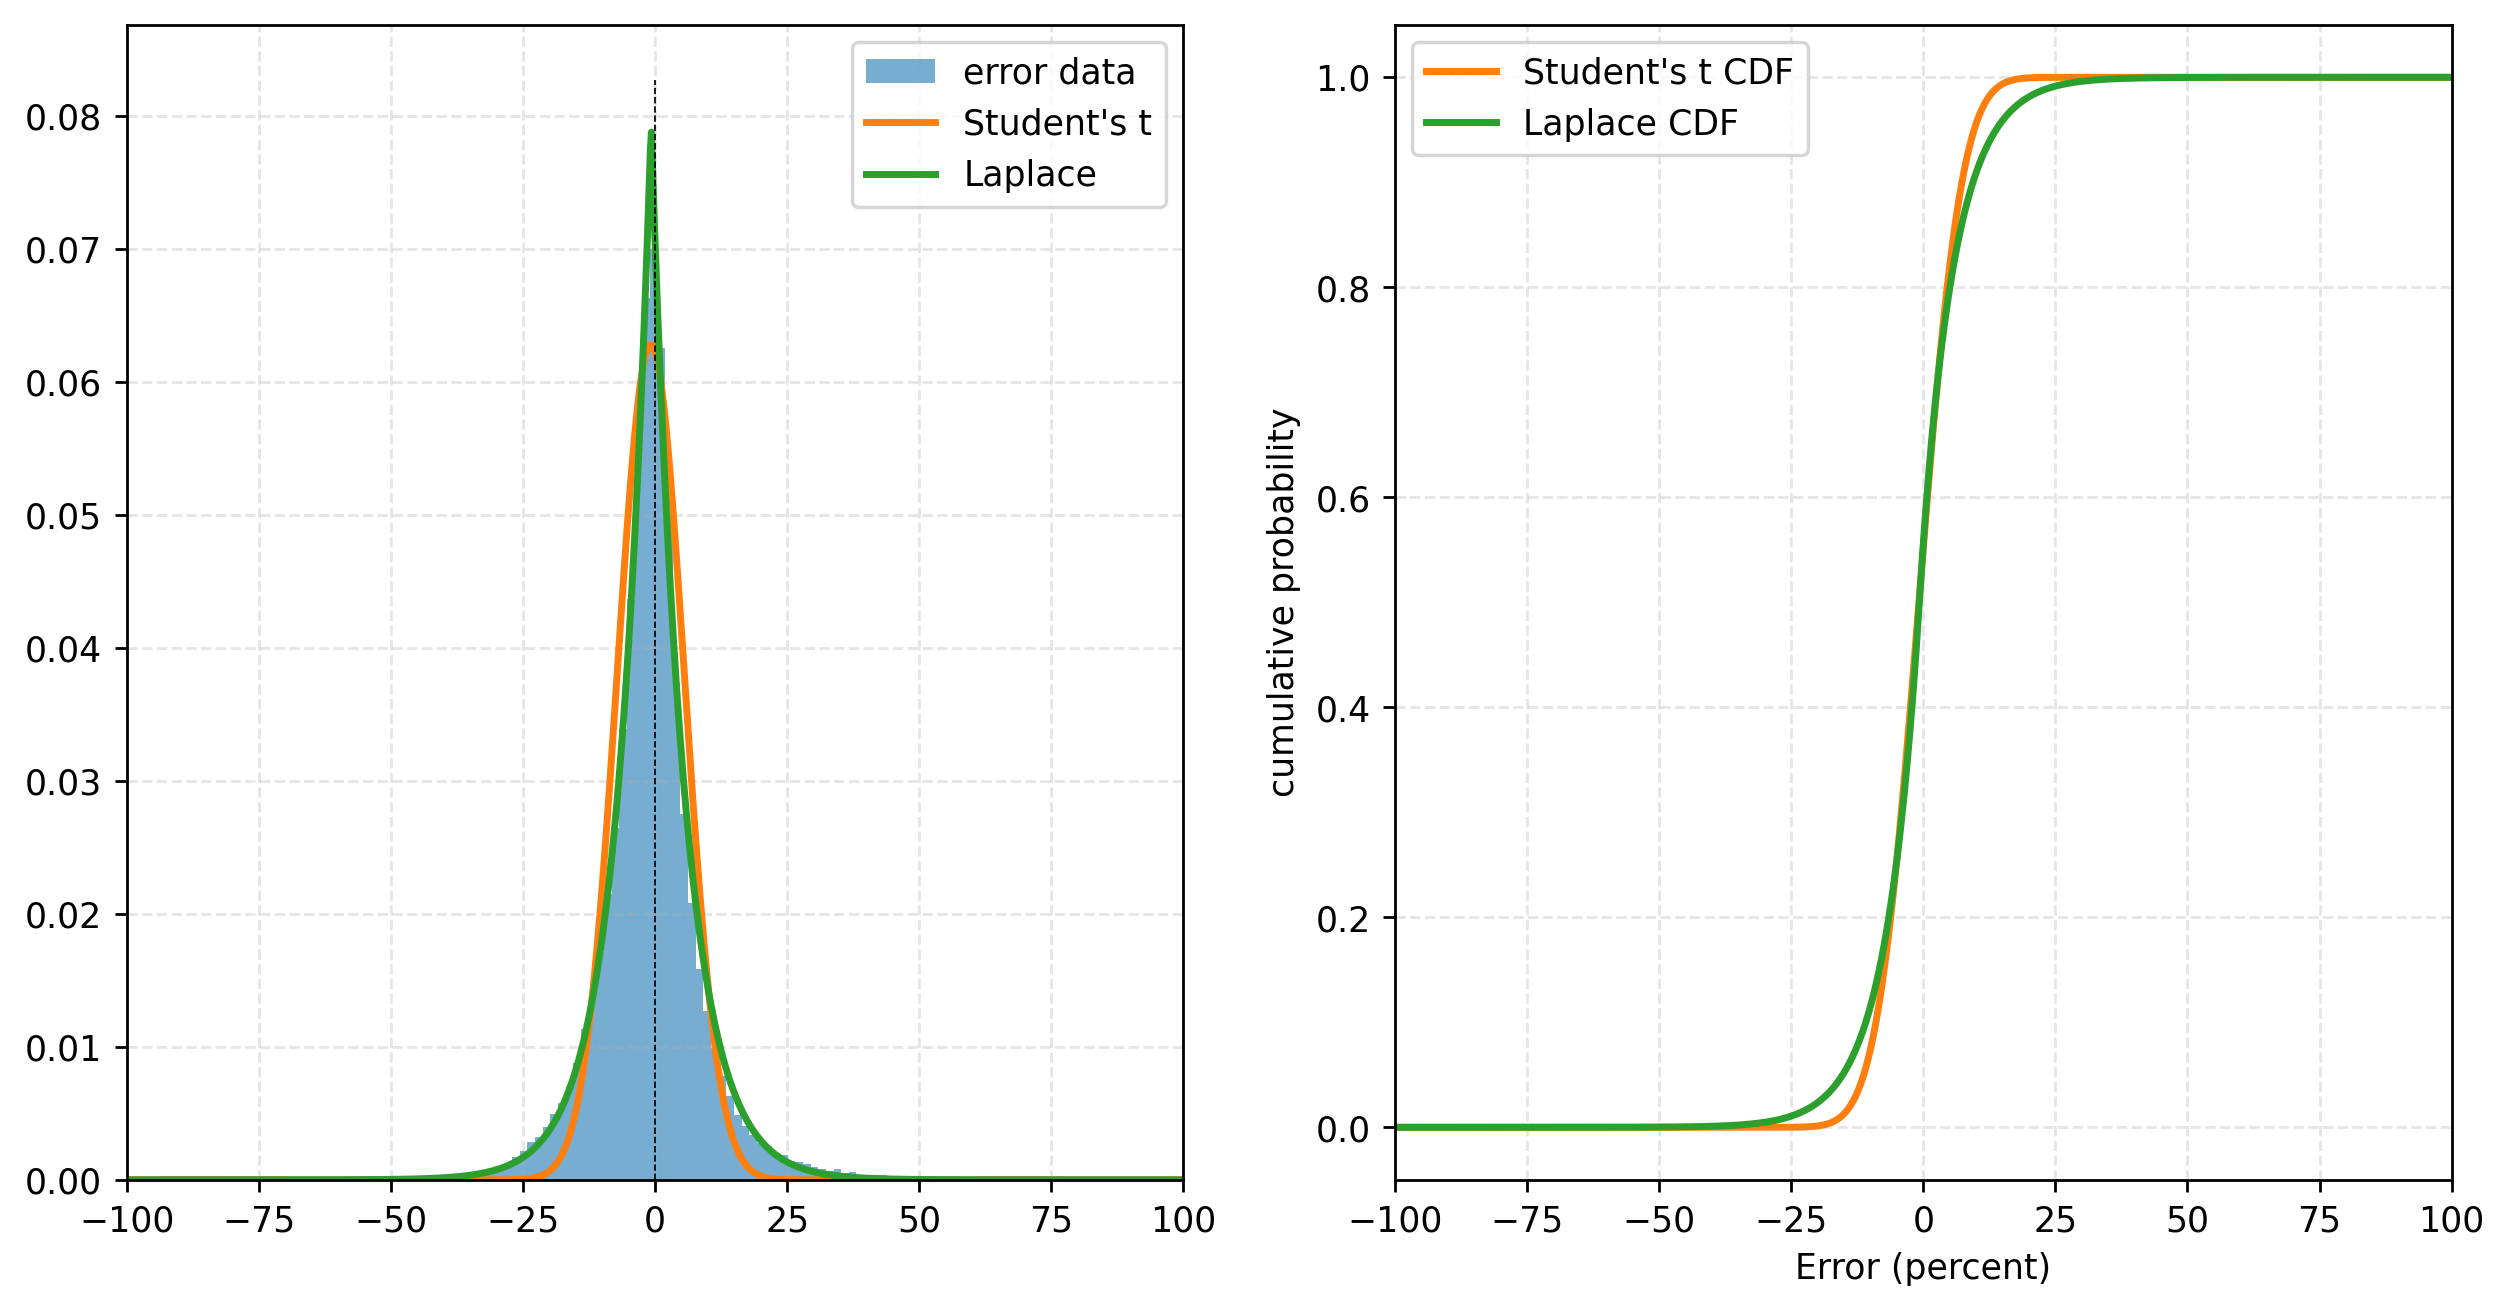

In [131]:
plot_distributions(data, n_bins=200, extreme_values=problem_percentages(2023))

The Laplace distribution seems to fit the historical error data well. The normal and Student's distributions essentially overlapped (the degrees of freedom are quite high).

The Laplace distribution can be used to [model errors when different observers have different error variances](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1740-9713.2018.01185.x). This fits our case, because the forecast at each timepoint prior to the window being forecasted could have its own error variance. (The historical data, however, has only one forecast per window.)

These results give a picture of the probability of an error in the final forecast data, for each time window. This is updated within 30 minutes of the window itself, so these forecasts are of limited value for prediction.

## Predicting error probability from real data

The above is using the final forecasts downloaded from the website.

Below, I'm calculating the same using actual data, including all downloaded forecasts for every window.

In [211]:
# Example to plot individual plots
summaries_merged_df = get_merged_summaries_with_final_actual_intensities("data", filter="national")

# Get the year's data so far
dt = datetime(2023,1,1,1,0).astimezone(timezone.utc)
dates = get_dates(summaries_merged_df, num_days=366, start_date=dt)
df_summary = summaries_merged_df.loc[dates].copy()
df_err, df_pc_err = _error_and_percentage_error(df_summary)

# Only pre-timepoint forecasts
df_err = df_err[[c for c in df_err.columns if float(c) >= 0.0]]
df_pc_err = df_pc_err[[c for c in df_pc_err.columns if float(c) >= 0.0]]

# Aggregate all forecasts and timepoints into one row per year
result = _aggregate_per(df_pc_err, "year")
df_year = result.T.copy()

print(f"half-hour timepoints: {len(dates)}; forecasts: {len(result.T)}")
result

half-hour timepoints: 1952; forecasts: 124315


0.0_49     0.0_50    0.0_51    0.0_52    0.0_53    0.0_54    0.0_55  \
2023 -10.526316 -11.538462 -7.317073 -8.333333 -7.228916 -3.488372  1.075269   

        0.0_56    0.0_57     0.0_58  ...  47.5_1843  47.5_1844  47.5_1845  \
2023 -3.030303 -8.653846 -17.094017  ...  -5.181347  -7.462687  -6.060606   

      47.5_1846  47.5_1847  47.5_1848  47.5_1849  47.5_1850  47.5_1851  \
2023  -7.920792  -4.522613   2.793296   7.100592     13.125  11.180124   

      47.5_1855  
2023        7.5  

[1 rows x 124315 columns]

Text(0, 0.5, 'forecast errors')

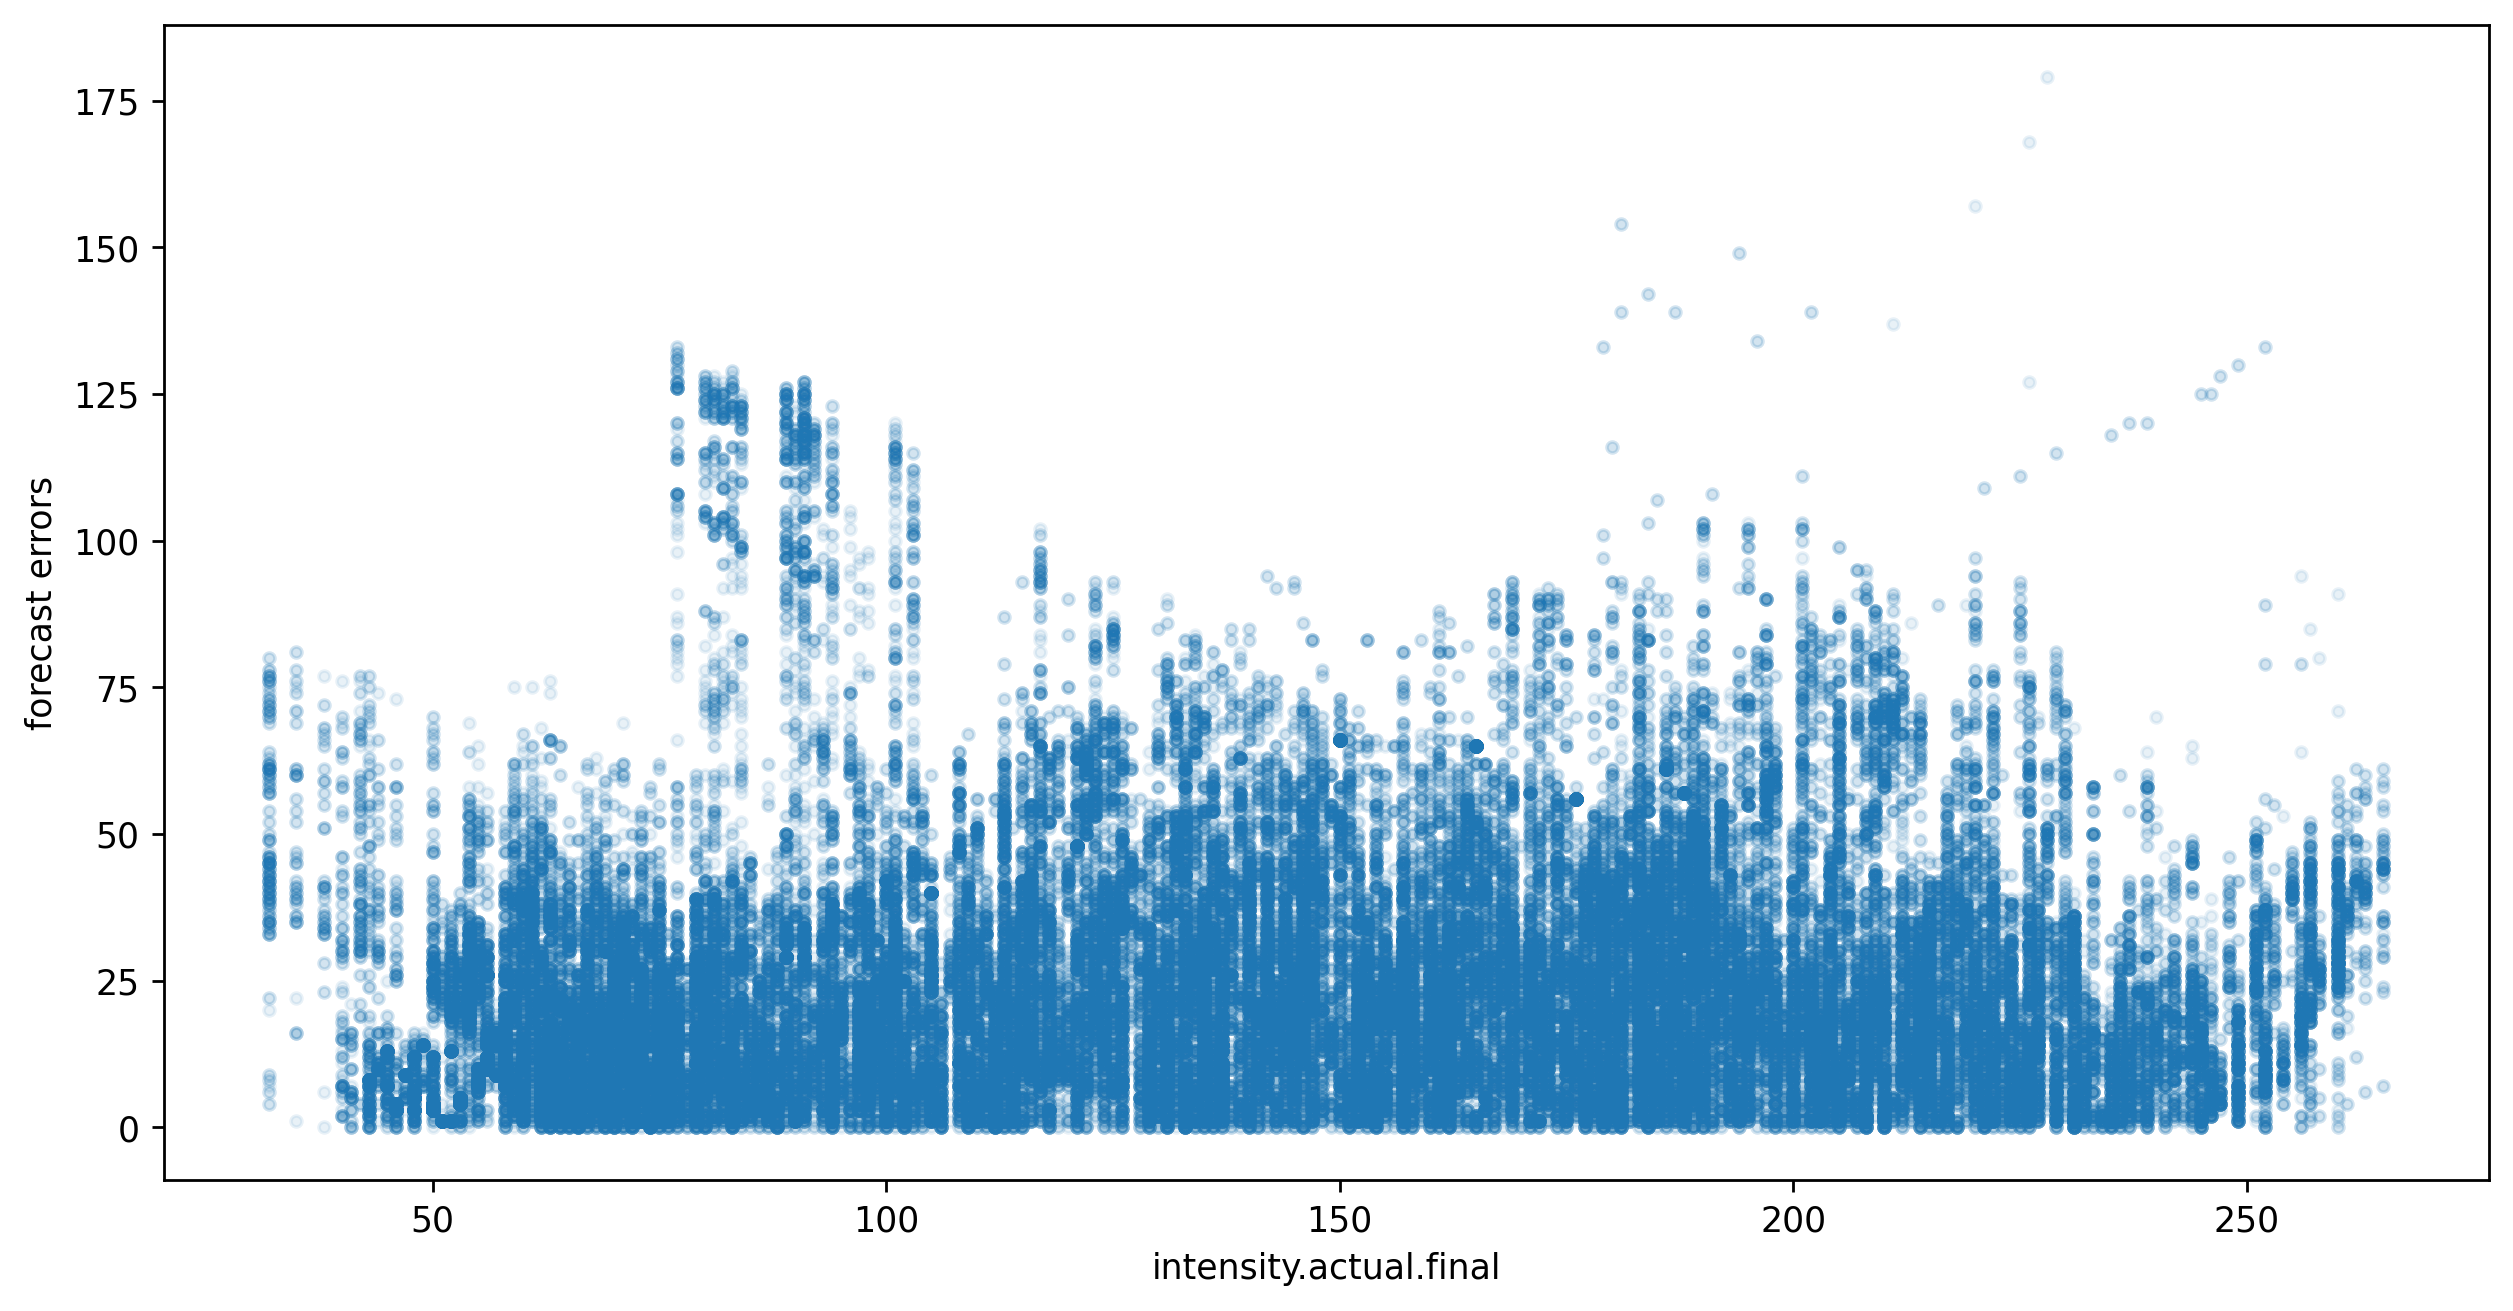

In [283]:
# df_err, df_pc_err = _error_and_percentage_error(df_summary)

df_actual = df_summary[["intensity.actual.final"]]
cols = df_actual.columns
df_actual.columns = cols.droplevel(1)

data = pd.concat([df_actual, df_err.abs()], axis=1)
# df_err
# df_summary.loc[:, "intensity.actual.final"]
# df_actual
# plt.scatter(x=data["intensity.actual.final"], y=)

x_col_name = "intensity.actual.final"

marker_properties = {
    'color': 'tab:blue',
    'marker': 'o',
    's': 10,  # size
    'alpha': 0.1
}

fig, ax = plt.subplots()

for column in data.columns[1:]:
    ax.scatter(data[x_col_name], data[column], **marker_properties)

ax.set_xlabel(x_col_name)
ax.set_ylabel("forecast errors")
# ax.legend()

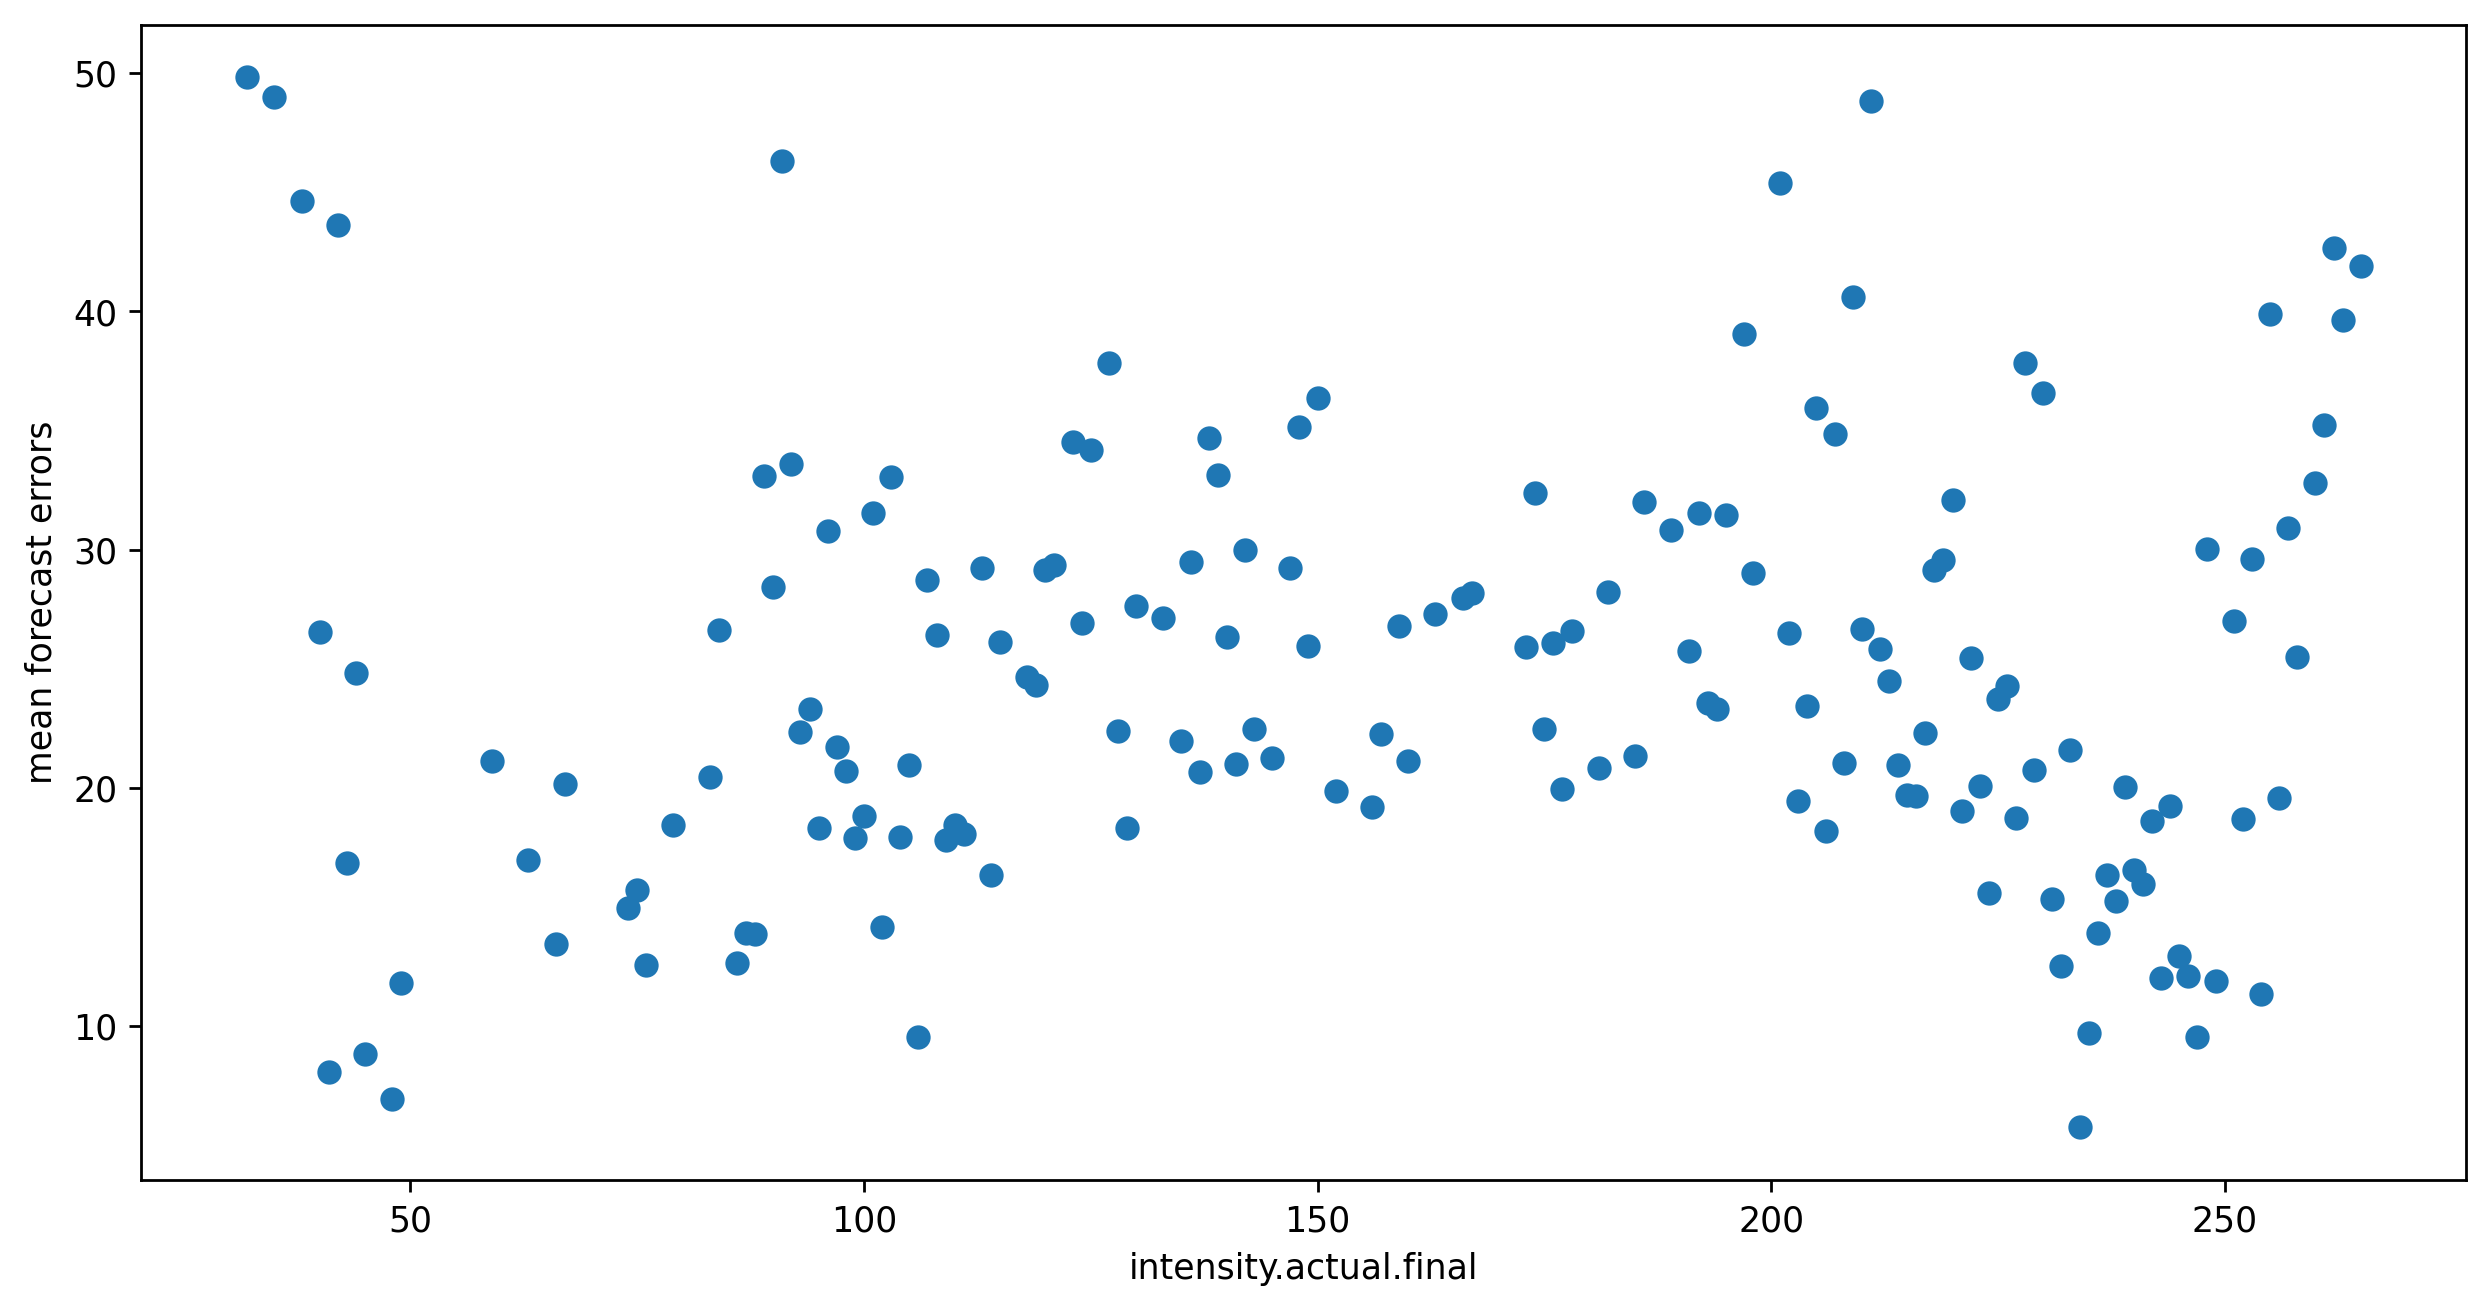

In [290]:
from collections import defaultdict

data_dict = defaultdict(list)

# Calculate the mean of the remaining columns
mean_values = data.iloc[:, 1:].mean(axis=1)

unique_keys = sorted(data[x_col_name].unique())
# data_dict = {key: [] for key in unique_keys}

# Gather all the data from the other columns for each key
for ix, row in data.iterrows():
    key = row[x_col_name]
    data_dict[key].append(row[1:].mean())

# Calculate the overall mean for each key
mean_dict = {key: np.mean(values) for key, values in data_dict.items()}

# Create scatterplot
fig, ax = plt.subplots()

ax.scatter(list(mean_dict.keys()), list(mean_dict.values()))

ax.set_xlabel(x_col_name)
ax.set_ylabel("mean forecast errors")

plt.show()

In [282]:
stats_df = df_year.abs().agg(["count", "mean", "median", "std", "sem"], axis=0).T
stats_df

count       mean     median        std       sem
2023  124315.0  19.908935  14.788732  20.314982  0.057618

55 excluded outliers, 0 nans, leaving 124260 data points


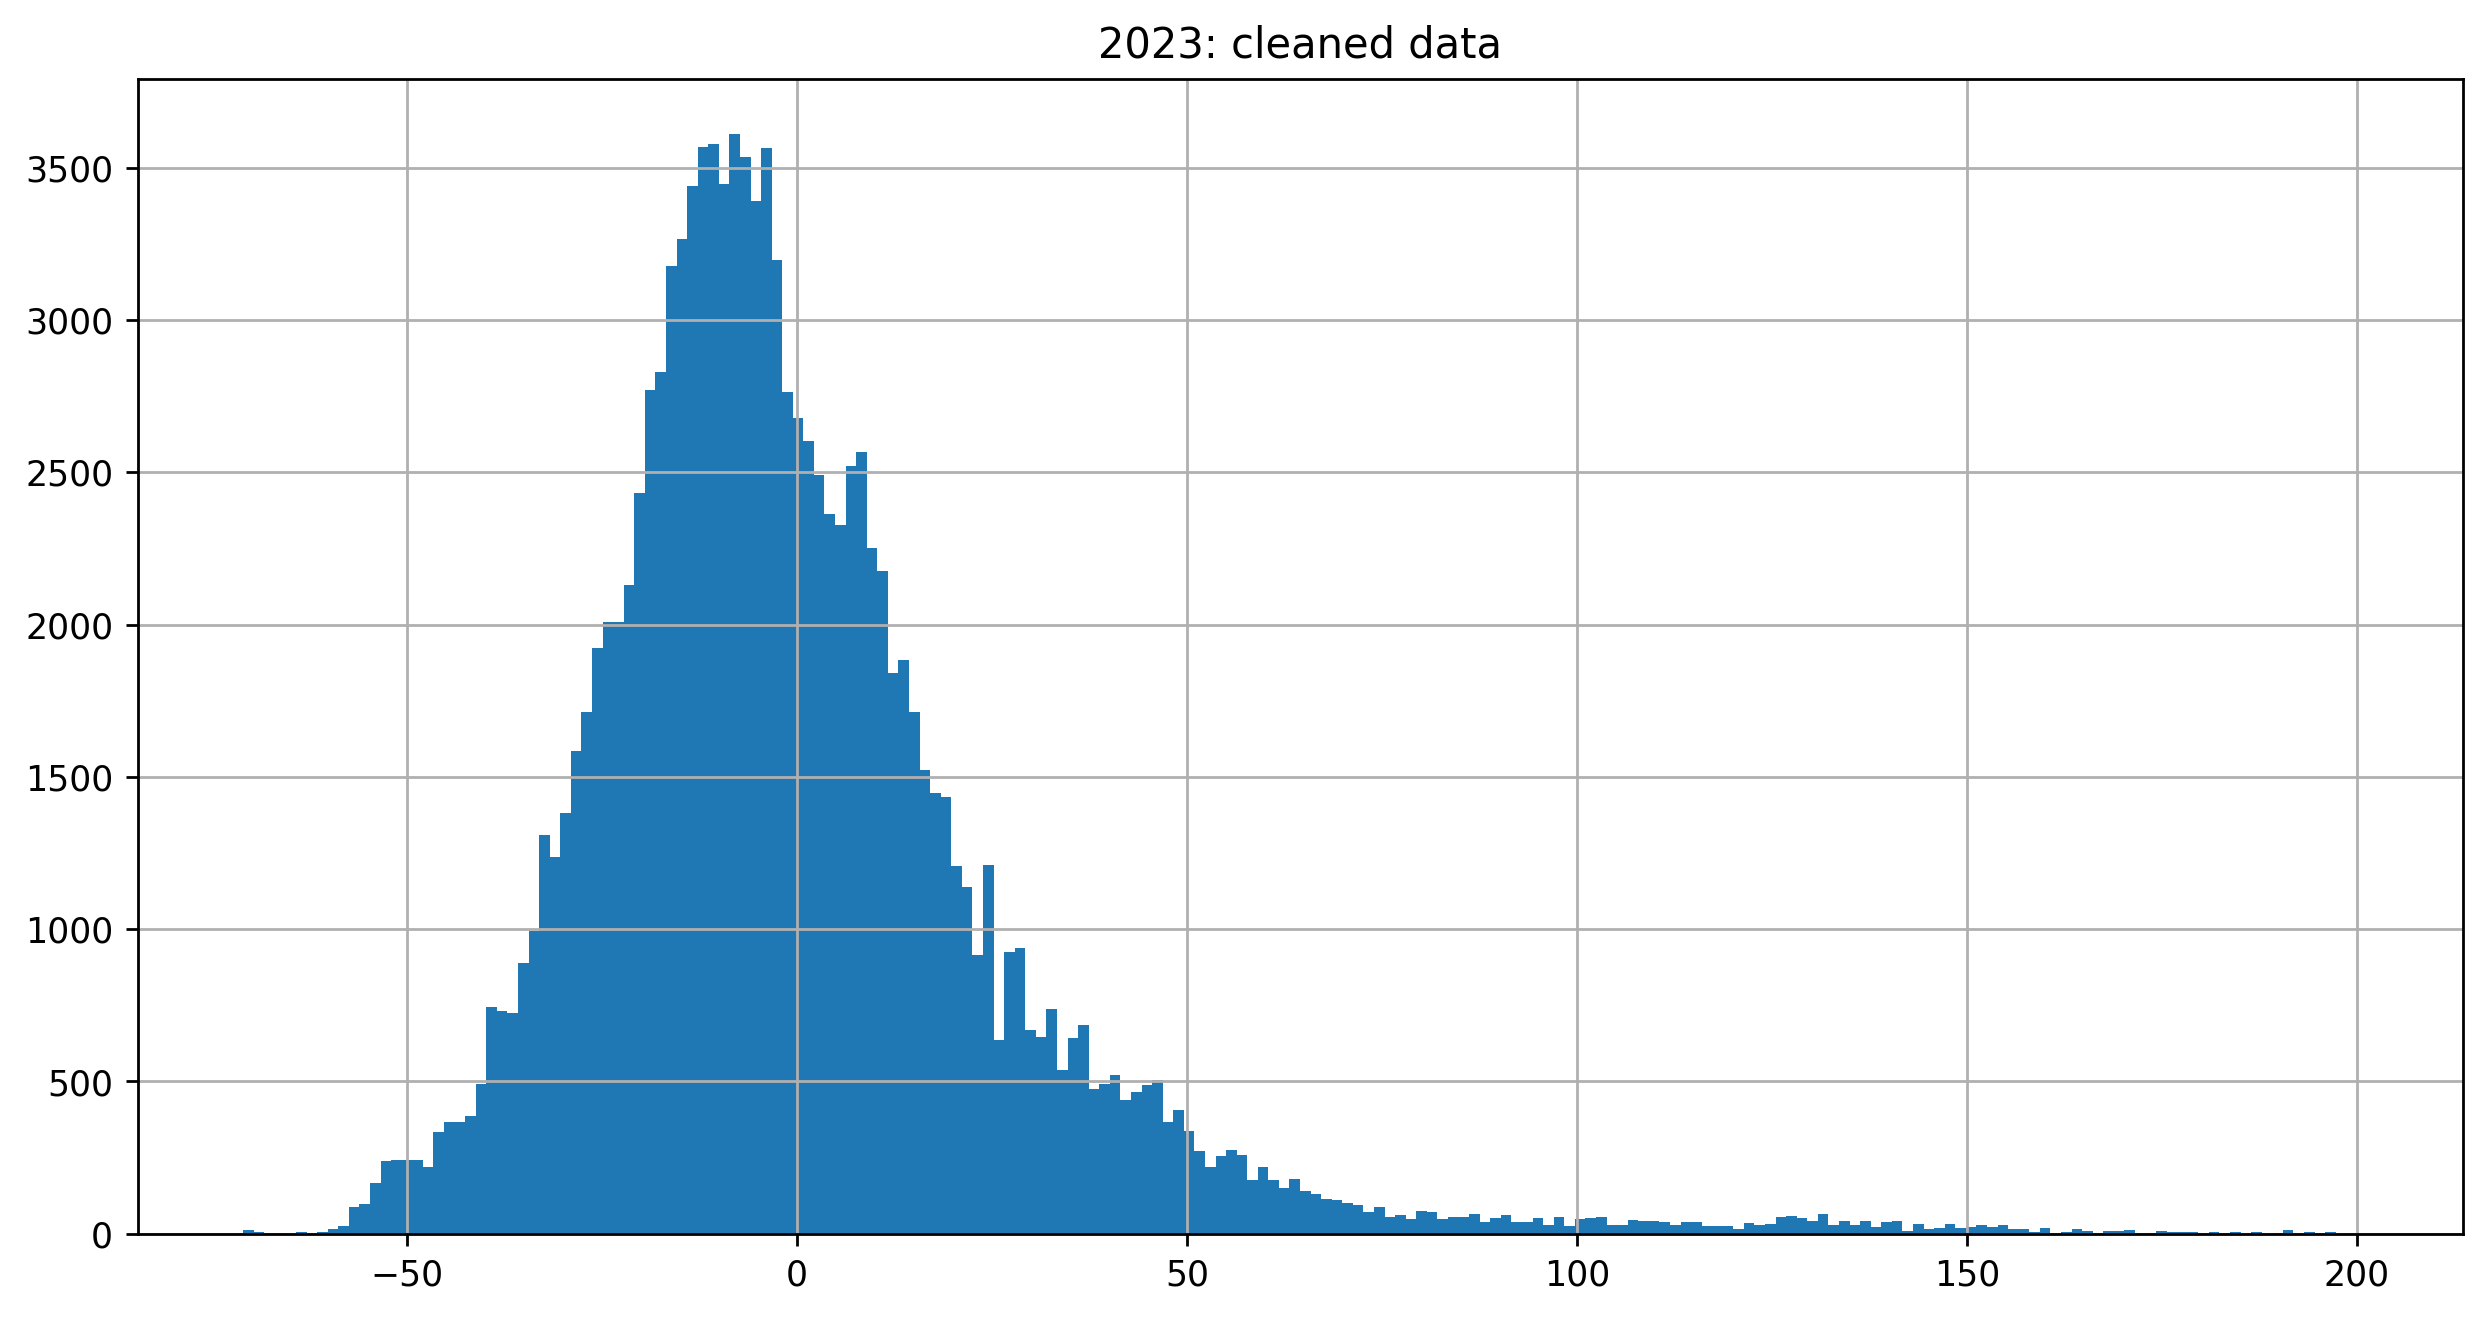

In [162]:
# Clean up as above
forecast_err_data = cleanup(df_year, 2023, max_cutoff=200)

Normal distribution parameters:
Mean: -5.980084818155337, Standard deviation: 20.19932503743799
Student's t-distribution parameters:
Mean: -5.977541647703506, Standard deviation: 20.190879182164736, Degrees of freedom: 4057745.1267385893
Laplace distribution parameters:
Mean: -7.227396433743487, Scale: 20.283121580656054
Total probability of extreme value 67.5 (Student's t-distribution): 0.0012923081712387936
Total probability of extreme value 67.5 (Laplace distribution): 0.03816998729886331
Total probability of extreme value 40.5 (Student's t-distribution): 0.054321255345256024
Total probability of extreme value 40.5 (Laplace distribution): 0.1444893184067952
Total probability of extreme value 31.61512027491409 (Student's t-distribution): 0.13339623278124763
Total probability of extreme value 31.61512027491409 (Laplace distribution): 0.22391098813377674


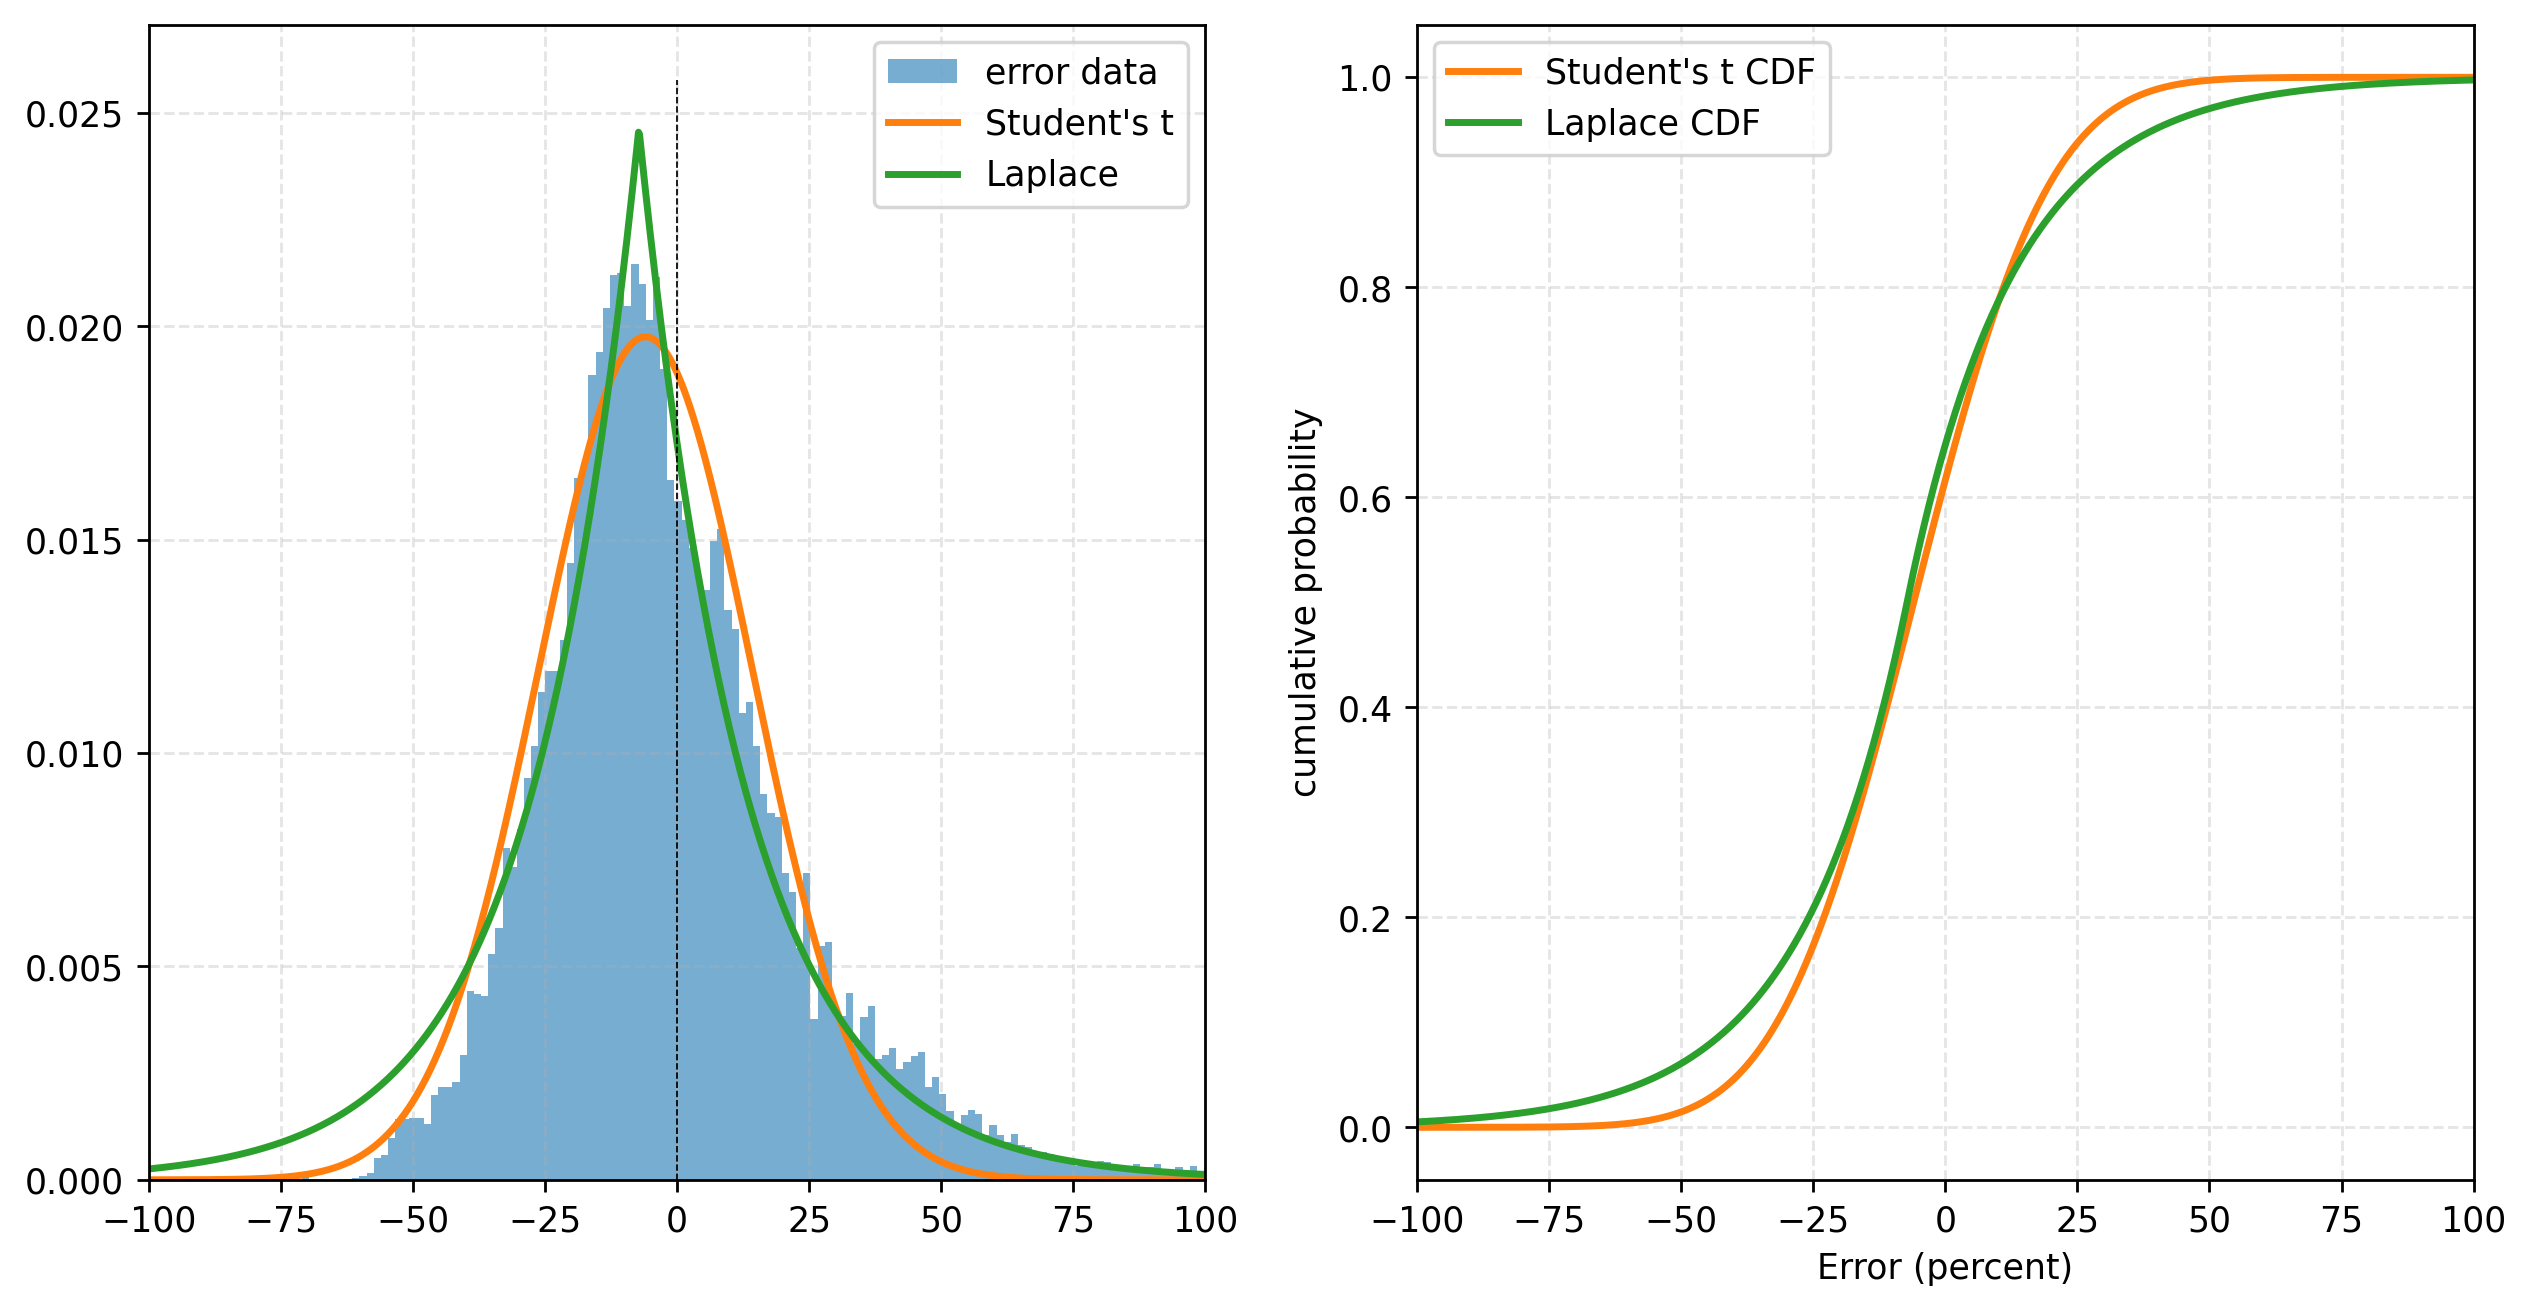

In [163]:
plot_distributions(forecast_err_data, n_bins=200, extreme_values=problem_percentages(2023))

With about 1 month's data so far, the distribution has a negative skew, and it is less clear that a Laplace distribution fits as well. Nevertheless, assuming such a distribution holds, and assuming the error is independent of the actual CI value, the chance of any `very low` forecast eventually materialising as a `moderate` or greater index is about $3.8\%$. Similarly:
| index range       | chance |
|-------------------|------------|
| very low - moderate (or greater) | 3.81%      |
| low - high (or greater) | 14.4%     |
| moderate - very high (or greater) | 22.4%    |